In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:

import os
import sys
import json

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [40]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [41]:
# where WellClass and Ga[ codes are located
sys.path.append('../')

In [42]:
# WellClass
# from well_class_v2 import csv_parser, Well
from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser
)

from src.WellClass.libs.well_class import Well
from src.WellClass.libs.well_pressure import Pressure

# plots
from src.WellClass.libs.plotting import (
    plot_pressure,
    plot_pt,
    plot_sketch,
)

## Some user options

In [43]:
# use yaml or csv input file
use_yaml = True

In [44]:
# pick an example from given three options

case_type = 'wildcat'

case_type = 'smeaheia_v1'

# case_type = 'smeaheia_v2'

In [45]:
# where pvt located
pvt_path = '../src/WellClass/libs/pvt/pvt_constants/pure_co2'

# Examples

The following are the test examples.

In [46]:
# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
               'sim_path': r'../test_data/examples/smeaheia_v1',
               'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
               'sim_path': r'../test_data/examples/smeaheia_v2', 
               'simcase': r'TEMP-0'}
wildcat = {
         'well_input': r'GaP_input_Wildcat_v3.csv', 
         'well_input_yaml': r'wildcat.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
         'sim_path': r'../test_data/examples/wildcat', 
         'simcase': r'TEMP-0'}

In [47]:
examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'wildcat': wildcat
}

# Load well CSV or yaml configuration file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [48]:
# the selected example for testing
case = examples[case_type]


In [49]:

# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

sim_path = case['sim_path']


In [50]:
if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)

In [51]:
#Process well by running well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
           )

## Generation of Pressure tables
### 1. Minimum input: 

The reservoir pressure dictionary needs to contain the `well_header`, the `co2_datum` and the `pvt_path`
It will create a table with a single scenario by default corresponding to the hydrostatic gradient.

In [52]:
my_pressure = Pressure(
    header      = well_csv['well_header'],
    # reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path,
    # max_pressure_pos = 500,
    # max_pressure_pos = my_well.barriers,
)

Computing pressures for pure CO2 (100% CO2)
Hydrostatic pressure at reference depth 1282 is 130.00
Pressure scenario hydrostatic: Compute pressures assuming reservoir pressure is 130.00 bar at 1282.50 mTVDMSL


In [53]:
pd.DataFrame(my_pressure.pressure_scenarios).T


,name,z_MSAD,from_resrvr,p_MSAD,p_resrv,z_resrv,p_delta
0,hydrostatic,551.915007,True,73.087402,129.995022,1282.5,0


### 2. Create a pressure scenario

Create a pressure scenario providing only the **MSAD** (the `from_resrv` flag has to be False )

In [54]:
my_pressure.create_pressure_scenario(name='test1', from_resrvr=False, z_MSAD=600)
pd.DataFrame(my_pressure.pressure_scenarios).T

Pressure scenario test1: Compute maximum pressurization needed to reach Shmin at 600 mTVDMSL


,name,z_MSAD,from_resrvr,p_MSAD,p_resrv,z_resrv,p_delta
0,hydrostatic,551.915007,True,73.087402,129.995022,1282.5,0
1,test1,600,False,81.237808,134.604586,1282.5,4.609563


Create a pressure scenario providing only the **delta Pressure +/-** at reservoir. The code assumes the reservoir depth is the same as the `co2_datum` (the `from_resrv` flag has to be True )

In [55]:
my_pressure.create_pressure_scenario(name='test2', from_resrvr=True, p_delta=50)
pd.DataFrame(my_pressure.pressure_scenarios).T

TESTING
Pressure scenario test2: Compute pressures assuming reservoir pressure is 180.00 bar at 1282.50 mTVDMSL


,name,z_MSAD,from_resrvr,p_MSAD,p_resrv,z_resrv,p_delta
0,hydrostatic,551.915007,True,73.087402,129.995022,1282.5,0
1,test1,600,False,81.237808,134.604586,1282.5,4.609563
2,test2,1093.163171,True,164.828965,179.995022,1282.5,50.0


Create a pressure scenario providing only the **delta Pressure +/-** at reservoir and the reservoir depth (the `from_resrv` flag has to be True )

In [56]:
my_pressure.create_pressure_scenario(name='test3', from_resrvr=True, p_delta=70, z_resrv=2300)

pd.DataFrame(my_pressure.pressure_scenarios).T

Pressure scenario test3: Compute pressures assuming reservoir pressure is 301.03 bar at 2300.00 mTVDMSL
Lines do not intersect


,name,z_MSAD,from_resrvr,p_MSAD,p_resrv,z_resrv,p_delta
0,hydrostatic,551.915007,True,73.087402,129.995022,1282.5,0
1,test1,600,False,81.237808,134.604586,1282.5,4.609563
2,test2,1093.163171,True,164.828965,179.995022,1282.5,50.0
3,test3,NaN,True,NaN,301.030048,2300,70.0


Create a pressure scenario providing a pressure measurement (value) and its correspoinding depth (the `from_resrv` flag has to be True )

In [57]:
my_pressure.create_pressure_scenario(name='test4', from_resrvr=True, z_resrv=2250, p_resrv=260)
pd.DataFrame(my_pressure.pressure_scenarios).T

Pressure scenario test4: Compute pressures assuming reservoir pressure is 260.00 bar at 2250.00 mTVDMSL


,name,z_MSAD,from_resrvr,p_MSAD,p_resrv,z_resrv,p_delta
0,hydrostatic,551.915007,True,73.087402,129.995022,1282.5,0
1,test1,600,False,81.237808,134.604586,1282.5,4.609563
2,test2,1093.163171,True,164.828965,179.995022,1282.5,50.0
3,test3,NaN,True,NaN,301.030048,2300,70.0
4,test4,913.717225,True,134.412878,260,2250,33.891187


In [58]:
my_pressure.pressure_CO2

init                                 hydrostatic             \
     depth_msl    temp        hs_p       Shmin         h2o        co2   
0            0    4.00    1.013250    1.013250    1.013250  38.061152   
1            1    4.00    1.113844    1.113844    1.113844  38.064208   
2            2    4.00    1.214438    1.214438    1.214438  38.067222   
3            3    4.00    1.315033    1.315033    1.315033  38.070194   
4            4    4.00    1.415628    1.415628    1.415628  38.073125   
...        ...     ...         ...         ...         ...        ...   
3657      3657  137.80  362.426487  599.399308  362.426487        NaN   
3658      3658  137.84  362.521618  599.568808  362.521618        NaN   
3659      3659  137.88  362.616745  599.738308  362.616745        NaN   
3660      3660  137.92  362.711870  599.907808  362.711870        NaN   
3661      3661  137.96  362.806992  600.077308  362.806992        NaN   

                                      test1              ...       test3  \
        co2_rho h2o_rho_in_co2_column   co2     co2_rho  ...         h2o   
0     31.384563           1027.621541   NaN         NaN  ...   70.305849   
1     30.928689           1027.621693   NaN         NaN  ...   70.406782   
2     30.486683           1027.621843   NaN         NaN  ...   70.507715   
3     30.058199           1027.621991   NaN         NaN  ...   70.608649   
4     29.642899           1027.622137   NaN         NaN  ...   70.709583   
...         ...                   ...   ...         ...  ...         ...   
3657        NaN                   NaN   NaN  476.216929  ...  432.824738   
3658        NaN                   NaN   NaN  476.175078  ...  432.920045   
3659        NaN                   NaN   NaN  476.133250  ...  433.015349   
3660        NaN                   NaN   NaN  476.091446  ...  433.110650   
3661        NaN                   NaN   NaN  476.049666  ...  433.205947   

                                                                     test4  \
          h2o_rho        co2     co2_rho h2o_rho_in_co2_column         h2o   
0     1029.222241  85.567395  943.779137           1029.975814   34.563004   
1     1029.227233  85.659955  943.844908           1029.980376   34.663763   
2     1029.232225  85.752526  943.910644           1029.984939   34.764522   
3     1029.237217  85.845110  943.976346           1029.989502   34.865282   
4     1029.242209  85.937706  944.042014           1029.994066   34.966042   
...           ...        ...         ...                   ...         ...   
3657   971.873568        NaN         NaN                   NaN  396.528372   
3658   971.841608        NaN         NaN                   NaN  396.623663   
3659   971.809643        NaN         NaN                   NaN  396.718951   
3660   971.777672        NaN         NaN                   NaN  396.814236   
3661   971.745697        NaN         NaN                   NaN  396.909519   

                                                                
          h2o_rho        co2     co2_rho h2o_rho_in_co2_column  
0     1027.447183  53.344620  917.620762           1028.381698  
1     1027.452207  53.434612  917.705310           1028.386166  
2     1027.457231  53.524613  917.789783           1028.390634  
3     1027.462255  53.614621  917.874181           1028.395103  
4     1027.467279  53.704638  917.958505           1028.399572  
...           ...        ...         ...                   ...  
3657   971.707981        NaN         NaN                   NaN  
3658   971.680546        NaN         NaN                   NaN  
3659   971.653106        NaN         NaN                   NaN  
3660   971.625663        NaN         NaN                   NaN  
3661   971.598215        NaN         NaN                   NaN  

[3662 rows x 28 columns]

# Visualization

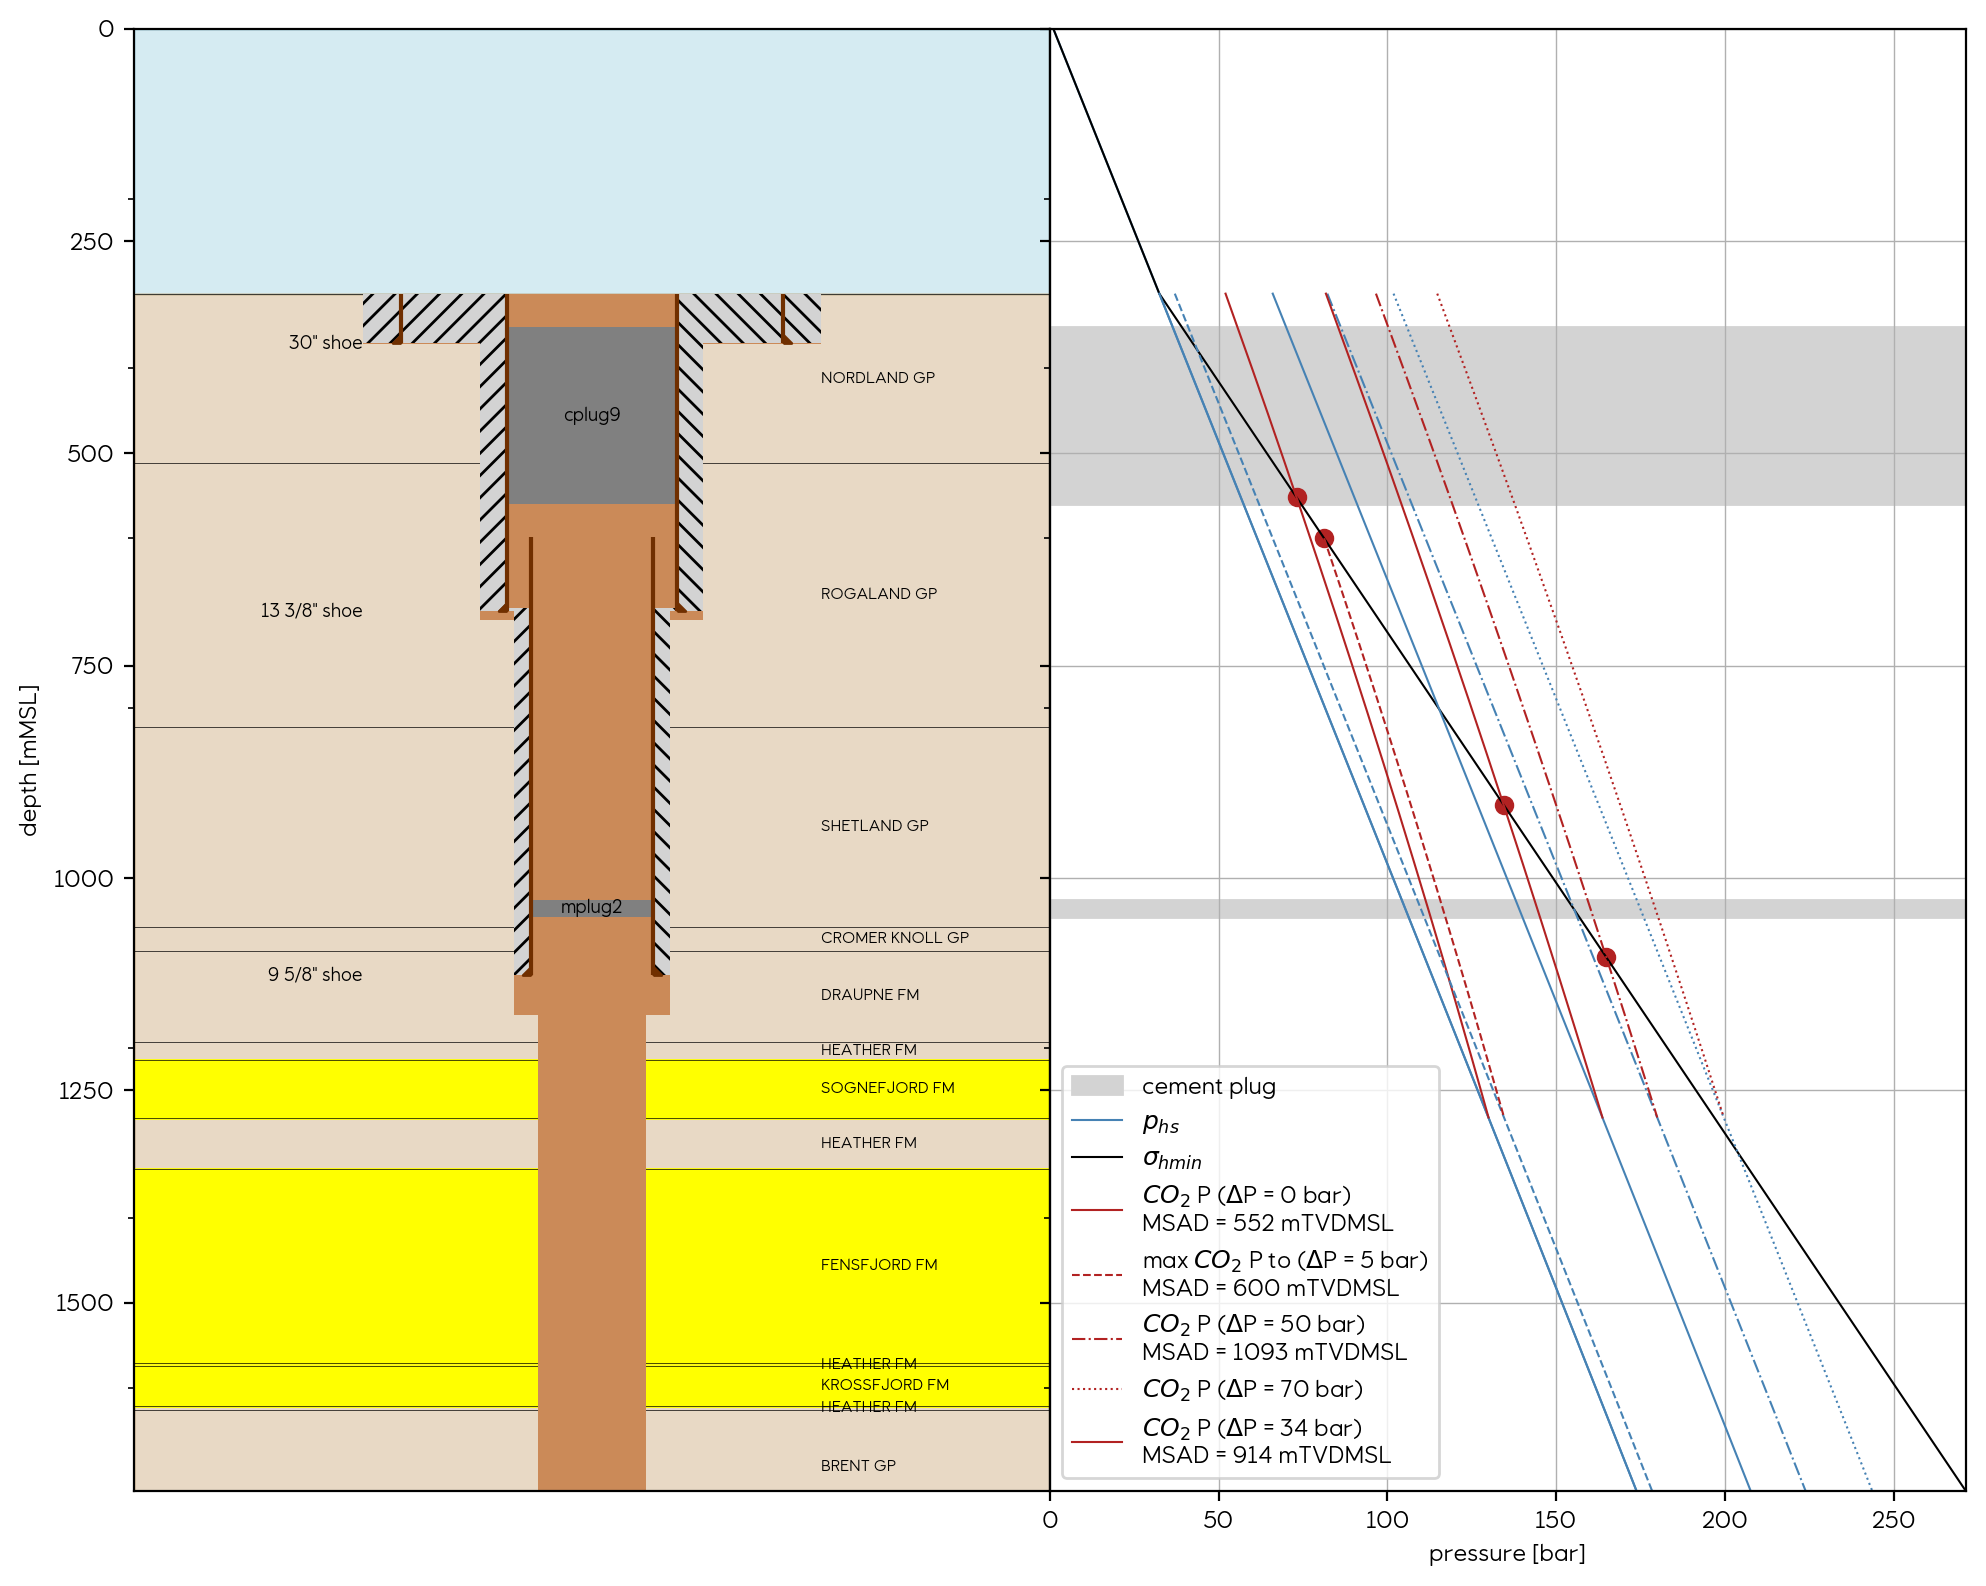

In [59]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
            #   plot_HSP=True, #plot brine hydrostatic gradient
              plot_RP=True, #plot reservoir pressure scenarios
              plot_MSAD= True, #plot minimum safety abandonment depth
              plot_maxP=True #plot max expected pressures
              )




fig.tight_layout()
fig.subplots_adjust(wspace=0)


## Test different fluid compositions

In [60]:
well_csv['reservoir_pressure']['depth_msl'] = 1215.75

In [61]:
pvt_path = '../src/WellClass/libs/pvt/pvt_constants/pure_co2'

my_pressure_pure_co2 = Pressure(
    header      = well_csv['well_header'],
    # reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path,
    # max_pressure_pos = 500,
    # max_pressure_pos = my_well.barriers,
)



Computing pressures for pure CO2 (100% CO2)
Hydrostatic pressure at reference depth 1282 is 130.00
Pressure scenario hydrostatic: Compute pressures assuming reservoir pressure is 130.00 bar at 1282.50 mTVDMSL


In [62]:
pvt_path_m1 = '../src/WellClass/libs/pvt/pvt_constants/mixture1'

my_pressure_mix1 = Pressure(
    header      = well_csv['well_header'],
    # reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path_m1,
    # max_pressure_pos = 500,
    # max_pressure_pos = my_well.barriers,
)

with open(pvt_path_m1 + "/metadata.json", "r") as file:
    mixture_info = json.load(file)

mixture1_name = mixture_info['name']
mixture1_composition = mixture_info['composition']


Computing pressures for mixture 1 (96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4)
Hydrostatic pressure at reference depth 1282 is 130.00
Pressure scenario hydrostatic: Compute pressures assuming reservoir pressure is 130.00 bar at 1282.50 mTVDMSL


In [63]:
pvt_path_m2 = '../src/WellClass/libs/pvt/pvt_constants/mixture2'

my_pressure_mix2 = Pressure(
    header      = well_csv['well_header'],
    # reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path_m2,
    # max_pressure_pos = 500,
    # max_pressure_pos = my_well.barriers,
)

with open(pvt_path_m2 + "/metadata.json", "r") as file:
    mixture_info = json.load(file)

mixture2_name = mixture_info['name']
mixture2_composition = mixture_info['composition']


Computing pressures for mixture 2 (95% CO2, 5% CH4)
Hydrostatic pressure at reference depth 1282 is 130.00
Pressure scenario hydrostatic: Compute pressures assuming reservoir pressure is 130.00 bar at 1282.50 mTVDMSL


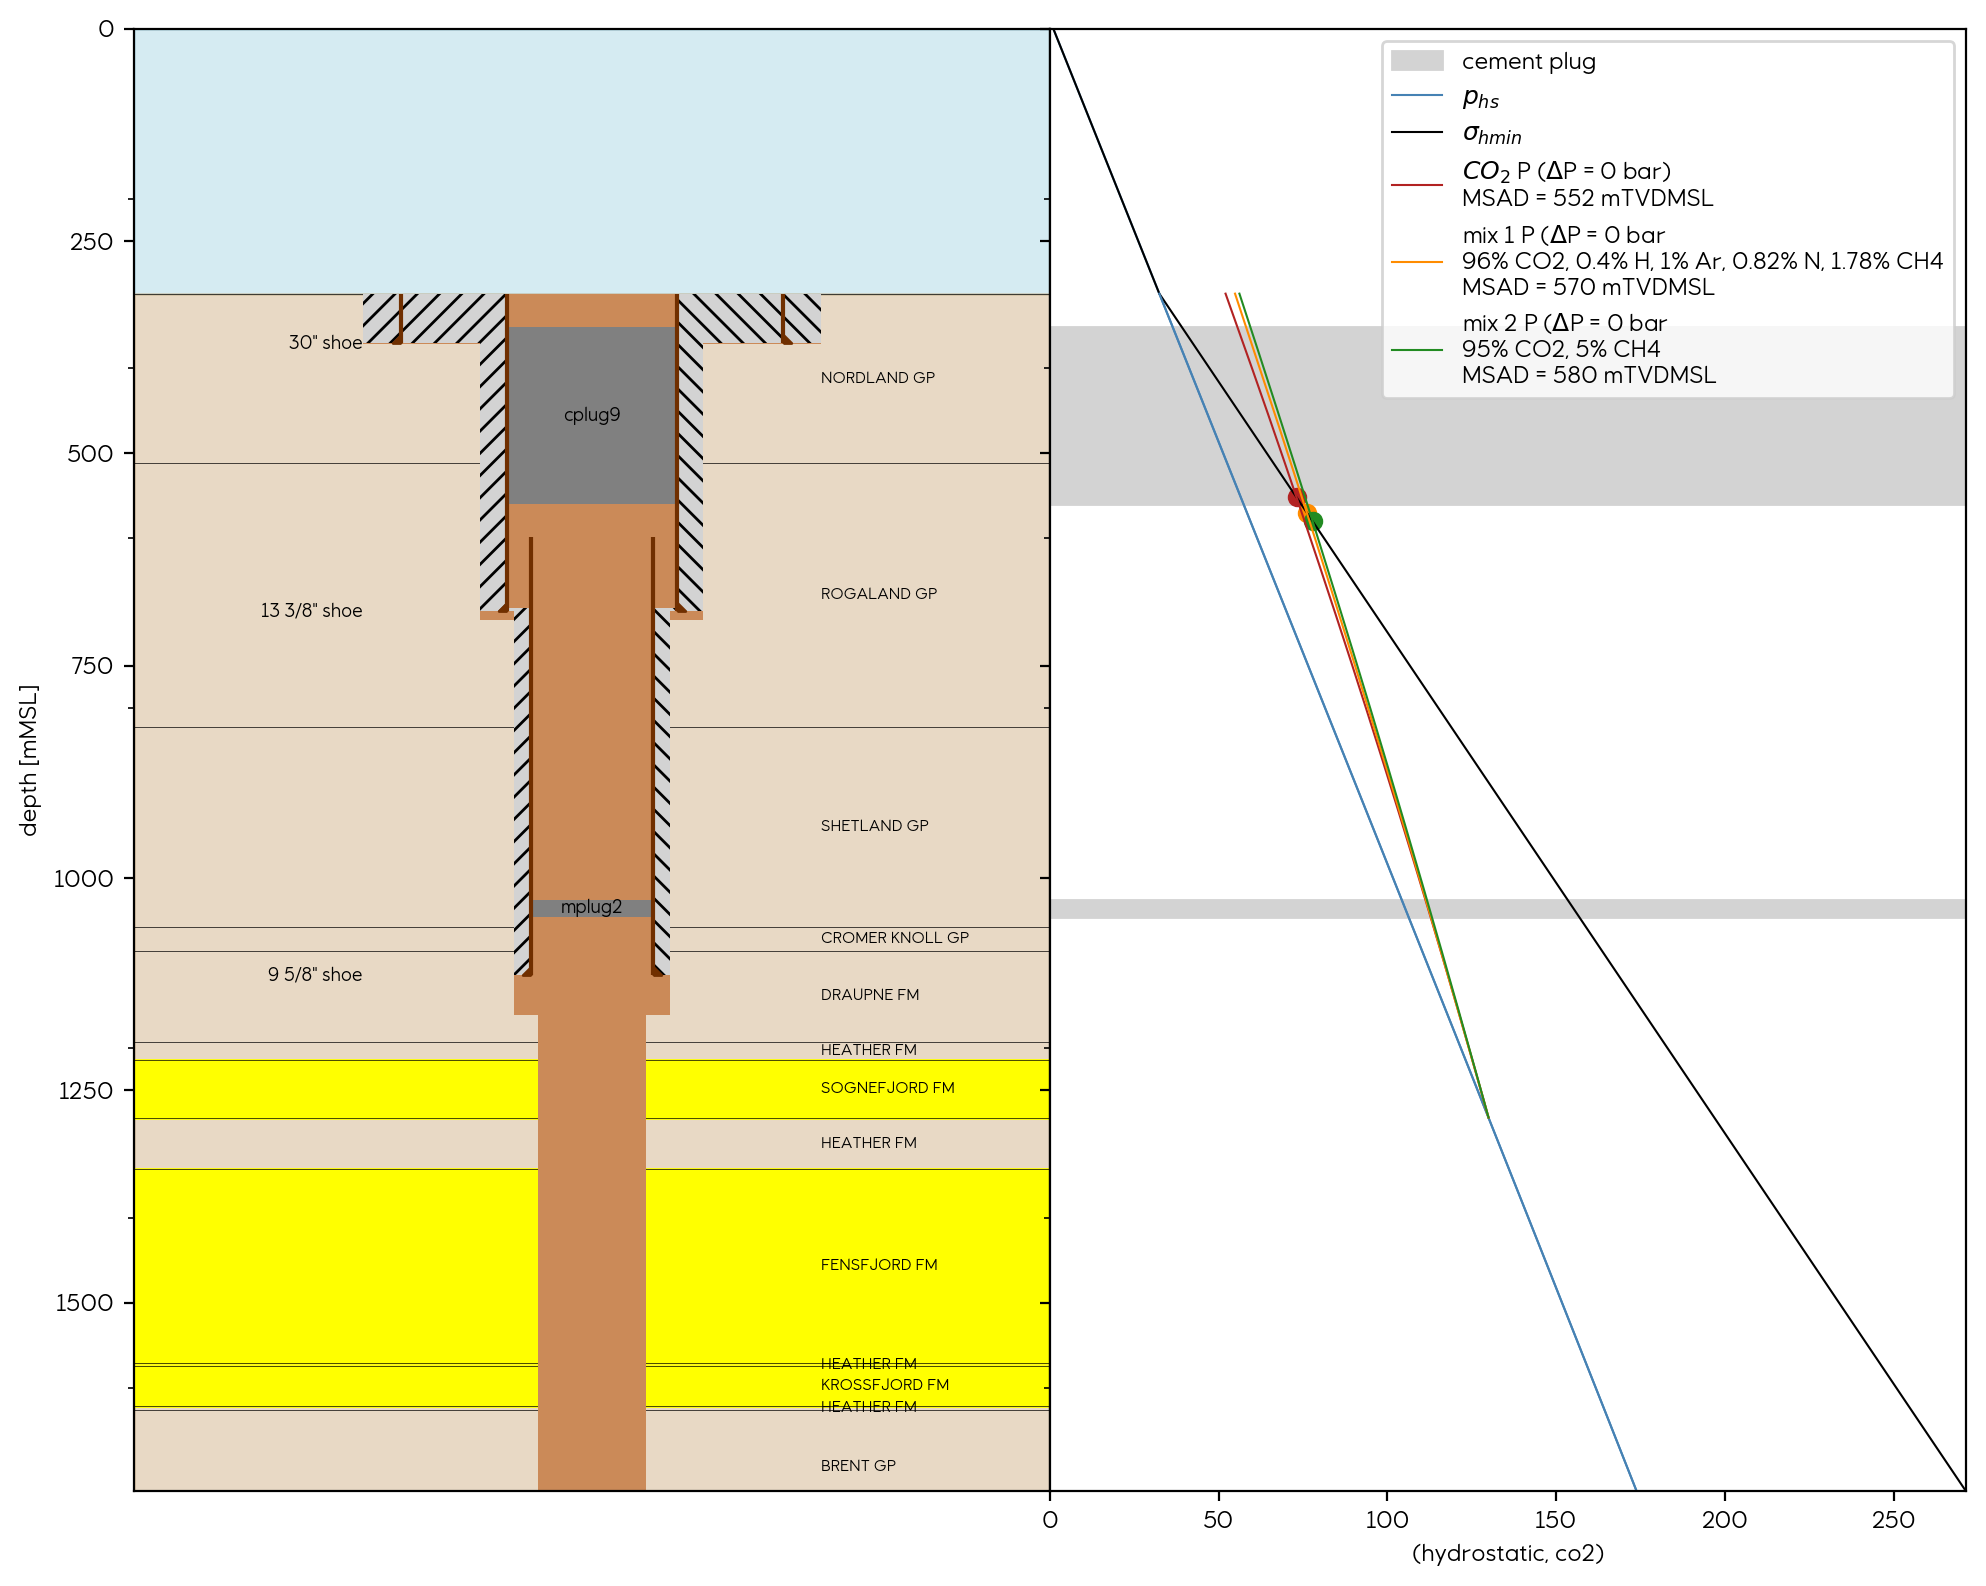

In [64]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure_pure_co2, my_well.geology, my_well.barriers, ax=ax2, 
            #   plot_HSP=True, #plot brine hydrostatic gradient
              plot_RP=True, #plot reservoir pressure scenarios
              plot_MSAD= True, #plot minimum safety abandonment depth
              plot_maxP=True #plot max expected pressures
              )

ls_list = ['solid','dashed','dashdot', 'dotted']


colors = ['firebrick', 'darkorange', 'forestgreen', 'royalblue']

for idx, case in enumerate([my_pressure_mix1, my_pressure_mix2]):

    counter = idx+1
    pt_df = case.pressure_CO2
    sc_delta_p = case.pressure_scenarios[0]['p_delta']
    sc_msad_p = case.pressure_scenarios[0]['p_MSAD']
    sc_msad_z = case.pressure_scenarios[0]['z_MSAD']
    sc_name = 'hydrostatic'
    sc_label = rf'mix {counter} P ($\Delta$P = {sc_delta_p:.0f} bar'
    sc_label = f'{sc_label}\n{case.mixture_composition}'
    sc_label = f'{sc_label}\nMSAD = {sc_msad_z:.0f} mTVDMSL'
                
    ax2.scatter(sc_msad_p, sc_msad_z, color=colors[counter])
    sf_depth = my_well.header['sf_depth_msl']
    pt_df[pt_df[('init', 'depth_msl')]>=sf_depth].plot(x=(sc_name, 'co2'), y=('init', 'depth_msl'), ax=ax2, label = sc_label, color=colors[counter], legend=False, lw = 0.75)


ax2.legend()
handles, labels = ax2.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
ax2.legend(lgd.values(), lgd.keys(), loc='upper right')

fig.tight_layout()
fig.subplots_adjust(wspace=0)

# CO2 Leakage

In [65]:
# pick one barrier
main_barrier = well_csv['main_barrier']
main_barrier

'cplug9'

In [66]:
# compute its leakage
barrier_leakage = my_pressure.compute_barrier_leakage(my_well, main_barrier)
barrier_leakage

barrier_perm:  [0.01, 10, 1000.0]


,0.01,10.00,1000.00
hydrostatic,0,0.01522,1.53367
test1,NaN,NaN,NaN
test2,0,0.03209,3.22014
test3,0,0.03897,3.90814
test4,0,0.02648,2.65963
